In [45]:
import os, glob
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used pad = 10
fwhm = 7
pad = 10
step = fwhm
fov = np.s_[pad:-pad:step, pad:-pad:step]

In [37]:
# Load Balltrack velocities
datadir = os.path.join(os.environ['DATA'], 'Ben/SteinSDO')
bfiles = sorted(glob.glob(os.path.join(datadir, 'balltrack/vxy*.npz')))
bvxys = [np.load(bfile) for bfile in bfiles]
bvxs = [bvxy['vx'] for bvxy in bvxys]
bvys = [bvxy['vy'] for bvxy in bvxys]

In [43]:
# Load Stein data
svx_files = sorted(glob.glob(os.path.join(datadir,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir,'SDO_vy*.fits')))
nframes = range(30, 81, 5)
tranges = [[0, nt] for nt in nframes]
#vx, vy = load_vel_mean((svx_files, svy_files), tranges[0])
vx_stein_l, vy_stein_l = zip(*[load_vel_mean((svx_files, svy_files), trange) for trange in tranges])

In [40]:
# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = zip(*[smooth_vel(vx, vy, fwhm, kernel='boxcar') for vx, vy in zip(vx_stein_l, vy_stein_l)])

In [41]:
# Calculate correlations
corrs = []
for i in range(len(tranges)):
    vx_stein = vx_stein_sm[i]
    vy_stein = vy_stein_sm[i]
    bvx = bvxs[i]
    bvy = bvys[i]
    corrs.append(calc_c_pearson(vx_stein, bvx, vy_stein, bvy, fov=fov))
    

In [42]:
corrs

[0.8976731754784865,
 0.9089164219679118,
 0.9170496796397689,
 0.9230605000116093,
 0.9286933522164346,
 0.9330218114055454,
 0.9370677009923014,
 0.9399577153135625,
 0.9424999473298058,
 0.9444791647566866,
 0.9466928428694152]

<IPython.core.display.Javascript object>


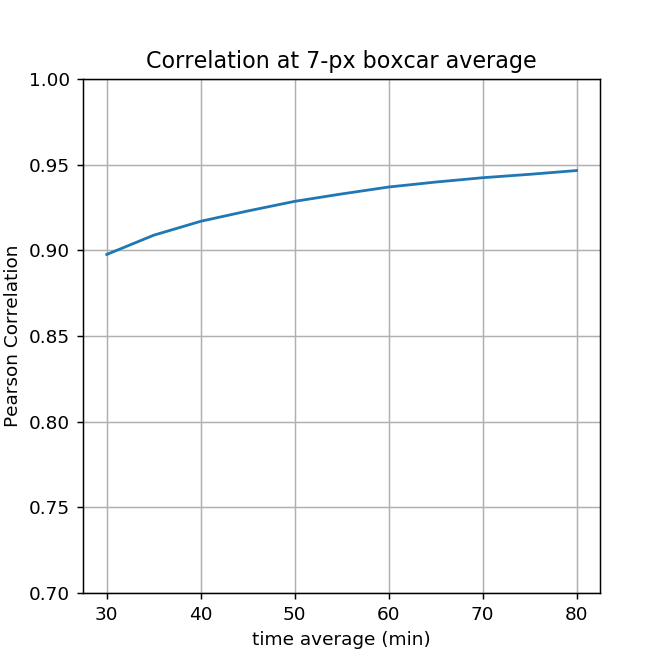

In [48]:
%matplotlib notebook
plt.figure(figsize=(5,5))
plt.plot(nframes, corrs)
plt.title('Correlation at 7-px boxcar average')
plt.xlabel('time average (min)')
plt.ylabel('Pearson Correlation')
plt.ylim([0.7, 1.0])
plt.grid()

In [71]:
bp, br, _, _, _ = np.polyfit(vx_stein_sm[0][fov].ravel(), bvxs[0][fov].ravel()*u, 1, full=True)

npts = vx_stein_sm[0][fov].size
br = np.sqrt(br[0]/npts)

In [72]:
# Load FLCT
from pathlib import Path
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi

u = 368000 / 60
vidx = 5
trange = [0,30]
datadir_flct = os.path.expanduser('~/Data/sanity_check/flct_results/')
lctfiles = sorted(list(Path(os.path.join(datadir_flct, 'Stein-simulation-series')).rglob('flct-km-Stein-simul-*.save')))
vx_flct = read_vi(lctfiles[vidx], 'vx') 
vy_flct = read_vi(lctfiles[vidx], 'vy')

vx_flct = vx_flct[trange[0]:trange[1], ...].mean(axis=0)
vy_flct = vy_flct[trange[0]:trange[1], ...].mean(axis=0)

c_flct = calc_c_pearson(vx_stein_sm[0], vx_flct, vy_stein_sm[0], vy_flct, fov=fov)
fp, fr, _, _, _ = np.polyfit(vx_stein_sm[0][fov].ravel(), vx_flct[fov].ravel()*u, 1, full=True)

fr = np.sqrt(fr[0]/npts)
print(c_flct)

0.8572246993729283


<IPython.core.display.Javascript object>


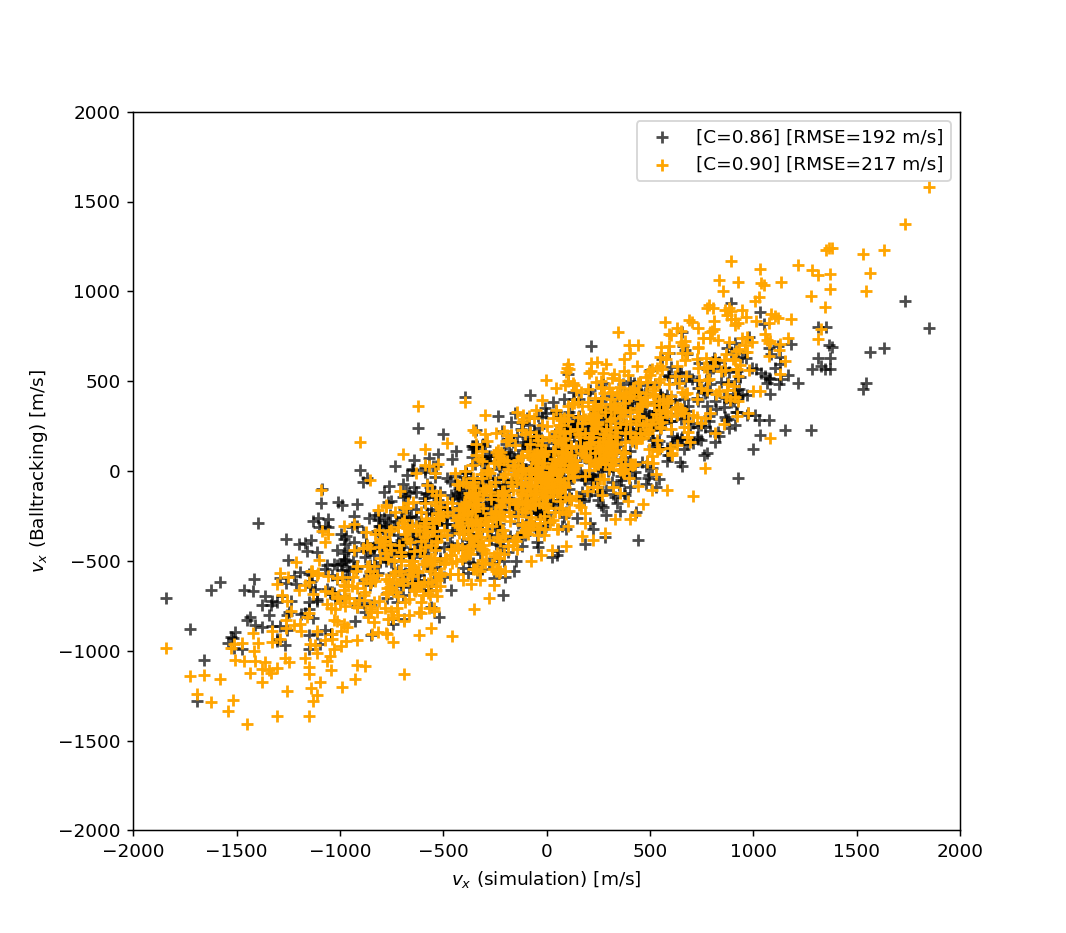

In [79]:
%matplotlib notebook

plt.figure(figsize=(8,7))
plt.scatter(vx_stein_sm[0][fov].ravel(), vx_flct[fov].ravel()*u, marker='+', color='black', alpha=0.7, label = '[C={:1.2f}] [RMSE={:1.0f} m/s]'.format(c_flct, fr))
plt.scatter(vx_stein_sm[0][fov].ravel(), bvxs[0][fov].ravel()*u, marker='+', color='orange', alpha=1.0, label = '[C={:1.2f}] [RMSE={:1.0f} m/s]'.format(corrs[0], br))
plt.axis([-2000, 2000, -2000, 2000])
plt.xlabel(r'$v_x$ (simulation) [m/s]')
plt.ylabel(r'$v_x$ (Balltracking) [m/s]')
plt.legend()

In [76]:
bvxs[0]

array([[ 0.00673375, -0.04332324, -0.10649924, ...,  0.03359267,
         0.02553579,  0.08410178],
       [-0.05123092, -0.09300401, -0.09962776, ...,  0.0329662 ,
         0.01173451,  0.00428917],
       [-0.04265   , -0.08999215, -0.09369293, ...,  0.02650065,
         0.01095973,  0.00237179],
       ...,
       [ 0.00971546,  0.02948398,  0.04978698, ...,  0.00097898,
         0.00218311,  0.00681002],
       [-0.01725575,  0.03732552,  0.05552242, ...,  0.01644107,
         0.01635891,  0.01032333],
       [-0.06462265, -0.00523395,  0.04717317, ...,  0.03045985,
         0.02878628,  0.03365956]])